# Loading dataset


In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2023-05-12 18:34:43--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-05-12 18:34:43--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  31.9MB/s    in 2.4s    

2023-05-12 18:34:46 (31.9 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [2]:
!unzip /content/trainingandtestdata.zip

Archive:  /content/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


<ipython-input-8-9163cea122c0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].replace(4,1)


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

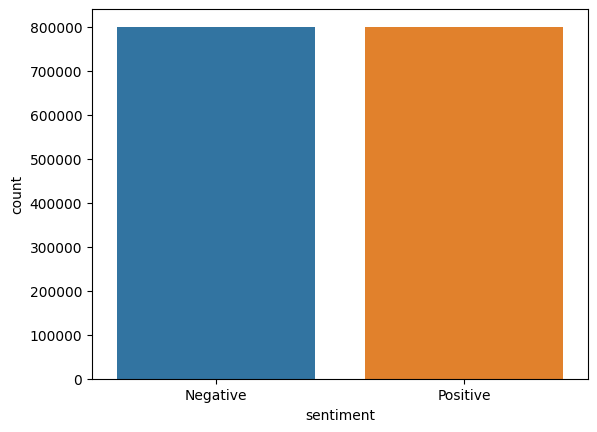

In [8]:
import pandas as pd
import seaborn as sns
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df=pd.read_csv("/content/training.1600000.processed.noemoticon.csv" , encoding='latin-1', header=None, names=DATASET_COLUMNS)
df = df[['sentiment','text']]
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)
ax= sns.countplot(x=df['sentiment'])
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [4]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
stop_words = stopwords.words("english")
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
nltk.download('wordnet')


def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stop_words:
              if len(word)>1:
                  # Lemmatizing the word.
                  word = wordLemm.lemmatize(word)
                  tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
processedtext = preprocess(df["text"])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
x_train_text, x_test_text, y_train, y_test = train_test_split(processedtext, df['sentiment'], test_size=0.2, random_state=42,stratify=df['sentiment'])

In [7]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:10<00:00, 37514.74it/s]


In [8]:
def get_tweet_words(glove_vector):
    train=  []
    for i, line in enumerate(processedtext):
        if i % 29 == 0:
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in line
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(df['sentiment'][i])).long()
            train.append((idxs, label))
    return train

train= get_tweet_words(glove)

In [9]:
train, test = train_test_split(train, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# Padding

In [79]:
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

tweet_padded = pad_sequence([torch.tensor(tweet) for tweet, label in train],
                            batch_first=True)
label_tensor = torch.tensor([label for tweet, label in train])
tweet_data = [(tweet_padded[i], label_tensor[i]) for i in range(len(train))]
x_train_text, test = train_test_split(tweet_data, test_size=0.2, random_state=42)
train, val = train_test_split(x_train_text, test_size=0.2, random_state=42)

<ipython-input-79-0a654b60c776>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tweet_padded = pad_sequence([torch.tensor(tweet) for tweet, label in train],


## Dataloader

In [10]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

## RNN Model

In [86]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [19]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [25]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total


In [ ]:
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(val, batch_size=64, drop_last=False)
test_loader = TweetBatcher(test, batch_size=64, drop_last=False)

Epoch 1; Loss 0.716639; Train Acc 0.548528; Val Acc 0.545107
Epoch 2; Loss 0.668211; Train Acc 0.552146; Val Acc 0.553755
Epoch 3; Loss 0.638777; Train Acc 0.556387; Val Acc 0.555576
Epoch 4; Loss 0.694224; Train Acc 0.553050; Val Acc 0.557761
Epoch 5; Loss 0.664538; Train Acc 0.569860; Val Acc 0.571142
Epoch 6; Loss 0.677211; Train Acc 0.571950; Val Acc 0.568138
Epoch 7; Loss 0.720956; Train Acc 0.575318; Val Acc 0.572508
Epoch 8; Loss 0.642513; Train Acc 0.560410; Val Acc 0.557123
Epoch 9; Loss 0.677672; Train Acc 0.545565; Val Acc 0.545562
Epoch 10; Loss 0.693755; Train Acc 0.557947; Val Acc 0.555030
Epoch 11; Loss 0.683643; Train Acc 0.557105; Val Acc 0.552025
Epoch 12; Loss 0.681079; Train Acc 0.567178; Val Acc 0.567865
Epoch 13; Loss 0.677953; Train Acc 0.566492; Val Acc 0.559763
Epoch 14; Loss 0.668107; Train Acc 0.573447; Val Acc 0.571325
Epoch 15; Loss 0.717147; Train Acc 0.574227; Val Acc 0.570232
Epoch 16; Loss 0.641673; Train Acc 0.584986; Val Acc 0.580155
Epoch 17; Loss 0.

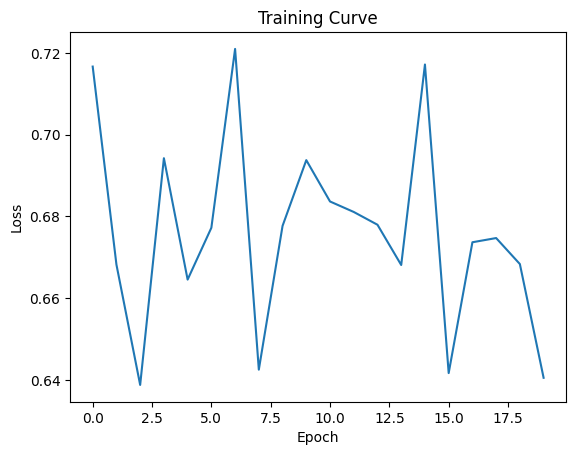

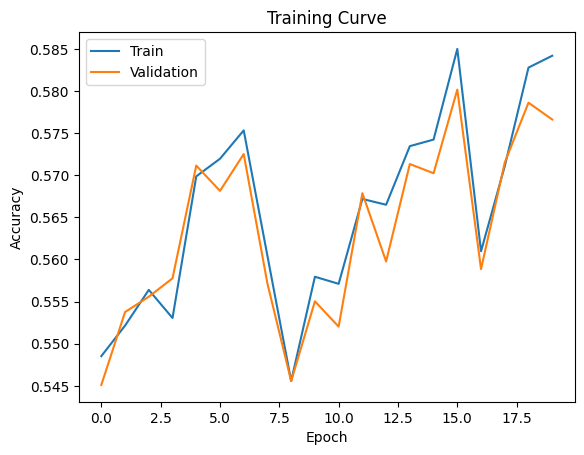

0.5678236312289332

In [88]:
model = TweetRNN(50, 150, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

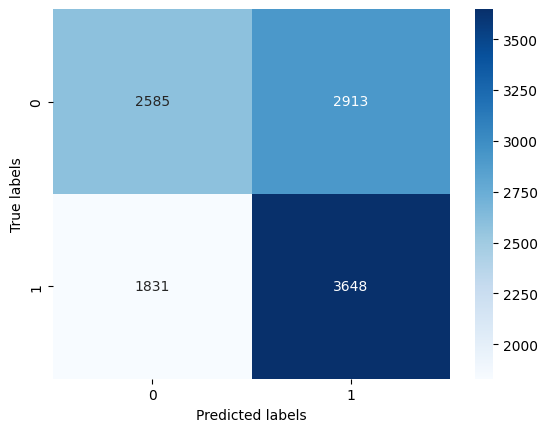

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# word2vec

In [7]:
class myRNN_w2v(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(myRNN_w2v, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [9]:
df_smaller = df.sample(frac = .1).reset_index()
processedtext = preprocess(df_smaller["text"])

In [10]:
documents = [_text.split() for _text in processedtext] 
from torch.utils.data import TensorDataset, DataLoader

In [30]:
from gensim.models import Word2Vec

output = df_smaller["sentiment"]
word2vec = Word2Vec(documents, min_count=2, vector_size=25)
input_token_vectors = [[word2vec.wv[token] 
                          for token in row if token in word2vec.wv] 
                              for row in documents]
output = [torch.tensor(int(row)).long() for row in output]
input = []
for row in input_token_vectors:
  pad_size = 30 - len(row)
  if len(row):
    input.append(np.concatenate((np.zeros((pad_size, 25)), np.array(row)) , axis=0))
  else:
    input.append(np.zeros((pad_size, 25)))
input = np.array(input).astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(input, output ,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train ,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)

train_loader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_train), torch.tensor(y_train)), batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_val), torch.tensor(y_val)), batch_size=32, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(torch.tensor(x_test), torch.tensor(y_test)), batch_size=32, shuffle=True, drop_last=True)

In [17]:
model = myRNN_w2v(25, 150, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
losses, train_acc, valid_acc, epochs = [], [], [], []

Epoch 1; Loss 0.648666; Train Acc 0.706258; Val Acc 0.700625
Epoch 2; Loss 0.626873; Train Acc 0.726867; Val Acc 0.718125
Epoch 3; Loss 0.358785; Train Acc 0.738449; Val Acc 0.726042
Epoch 4; Loss 0.532611; Train Acc 0.718210; Val Acc 0.706806
Epoch 5; Loss 0.516181; Train Acc 0.738927; Val Acc 0.724583
Epoch 6; Loss 0.580495; Train Acc 0.743326; Val Acc 0.729375
Epoch 7; Loss 0.440293; Train Acc 0.736381; Val Acc 0.725000
Epoch 8; Loss 0.461384; Train Acc 0.741188; Val Acc 0.725139
Epoch 9; Loss 0.603084; Train Acc 0.741404; Val Acc 0.728056
Epoch 10; Loss 0.531344; Train Acc 0.748557; Val Acc 0.733472
Epoch 11; Loss 0.469188; Train Acc 0.753210; Val Acc 0.731042
Epoch 12; Loss 0.512520; Train Acc 0.752809; Val Acc 0.733125
Epoch 13; Loss 0.616237; Train Acc 0.753410; Val Acc 0.733333
Epoch 14; Loss 0.546010; Train Acc 0.728735; Val Acc 0.712708
Epoch 15; Loss 0.438833; Train Acc 0.751142; Val Acc 0.736250
Epoch 16; Loss 0.530267; Train Acc 0.744892; Val Acc 0.726458
Epoch 17; Loss 0.

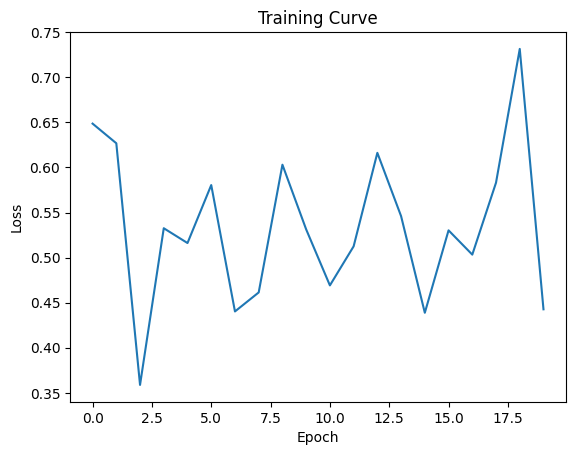

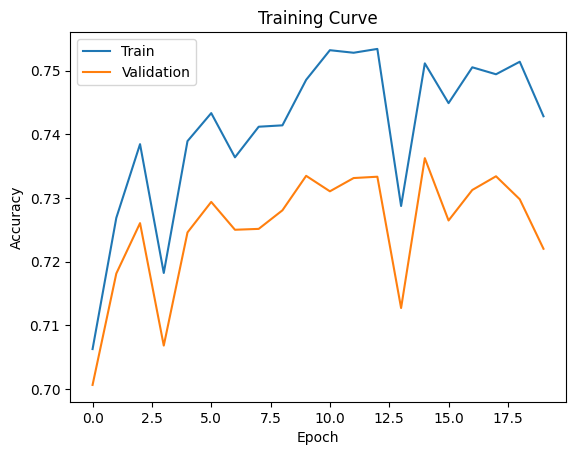

0.7299375

In [31]:
model_rnn_w2v = myRNN_w2v(25, 150, 2)
train_rnn_network(model_rnn_w2v, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)
get_accuracy(model_rnn_w2v, test_loader)

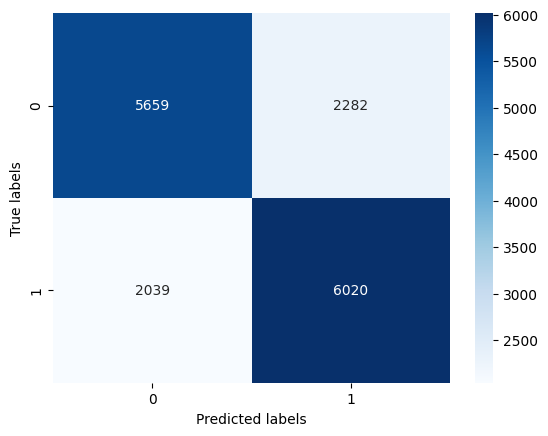

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model_rnn_w2v.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_rnn_w2v(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# One hot

# LSTM

## One hot

## Glove

Epoch 1; Loss 0.672144; Train Acc 0.556044; Val Acc 0.554119
Epoch 2; Loss 0.628066; Train Acc 0.597742; Val Acc 0.591534
Epoch 3; Loss 0.680349; Train Acc 0.629491; Val Acc 0.624124
Epoch 4; Loss 0.727235; Train Acc 0.692365; Val Acc 0.685571
Epoch 5; Loss 0.557714; Train Acc 0.704965; Val Acc 0.692490
Epoch 6; Loss 0.592470; Train Acc 0.739396; Val Acc 0.719709
Epoch 7; Loss 0.475438; Train Acc 0.752152; Val Acc 0.727811
Epoch 8; Loss 0.395889; Train Acc 0.771769; Val Acc 0.744197
Epoch 9; Loss 0.390476; Train Acc 0.790856; Val Acc 0.748748
Epoch 10; Loss 0.488733; Train Acc 0.815182; Val Acc 0.769231
Epoch 11; Loss 0.453698; Train Acc 0.837949; Val Acc 0.780701
Epoch 12; Loss 0.338025; Train Acc 0.860435; Val Acc 0.797633
Epoch 13; Loss 0.353166; Train Acc 0.876653; Val Acc 0.805644
Epoch 14; Loss 0.302110; Train Acc 0.892122; Val Acc 0.814019
Epoch 15; Loss 0.315704; Train Acc 0.907934; Val Acc 0.824124
Epoch 16; Loss 0.295483; Train Acc 0.923902; Val Acc 0.835503
Epoch 17; Loss 0.

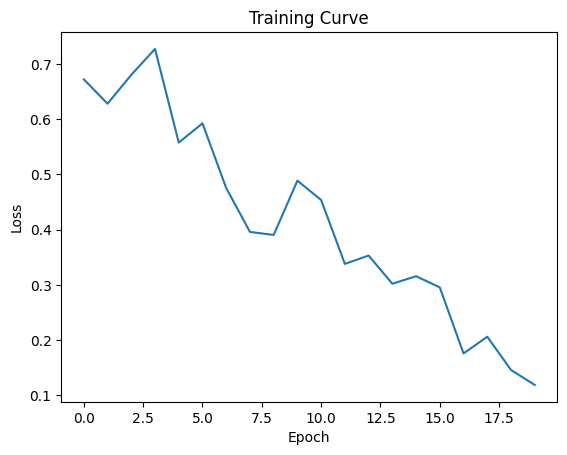

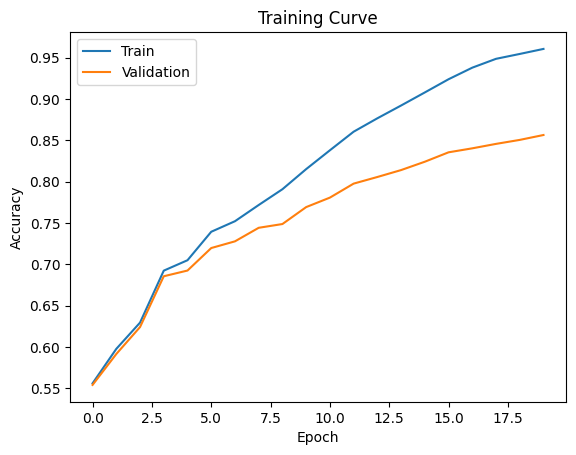

0.677052017855516

In [94]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_lstm = TweetLSTM(50, 150, 2)
train_rnn_network(model_lstm, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)
get_accuracy(model_lstm, test_loader)

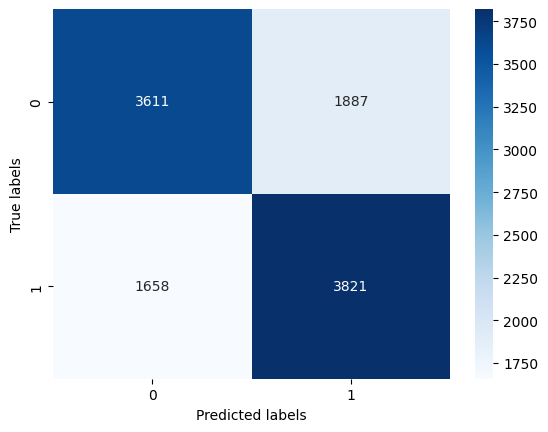

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model_lstm.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_lstm(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# GRU

## One hot

## Glove

Epoch 1; Loss 0.684068; Train Acc 0.524919; Val Acc 0.524937
Epoch 2; Loss 0.689420; Train Acc 0.535273; Val Acc 0.536438
Epoch 3; Loss 0.689213; Train Acc 0.538829; Val Acc 0.534389
Epoch 4; Loss 0.692878; Train Acc 0.539265; Val Acc 0.535983
Epoch 5; Loss 0.677111; Train Acc 0.543600; Val Acc 0.545775
Epoch 6; Loss 0.699302; Train Acc 0.546657; Val Acc 0.542359
Epoch 7; Loss 0.696080; Train Acc 0.545846; Val Acc 0.542587
Epoch 8; Loss 0.674333; Train Acc 0.547436; Val Acc 0.542815
Epoch 9; Loss 0.699037; Train Acc 0.545815; Val Acc 0.546573
Epoch 10; Loss 0.683085; Train Acc 0.550524; Val Acc 0.546117
Epoch 11; Loss 0.702273; Train Acc 0.549994; Val Acc 0.549533
Epoch 12; Loss 0.673997; Train Acc 0.551927; Val Acc 0.551924
Epoch 13; Loss 0.687014; Train Acc 0.552769; Val Acc 0.552266
Epoch 14; Loss 0.681910; Train Acc 0.555576; Val Acc 0.552380
Epoch 15; Loss 0.657986; Train Acc 0.558290; Val Acc 0.551469
Epoch 16; Loss 0.666699; Train Acc 0.561284; Val Acc 0.556365
Epoch 17; Loss 0.

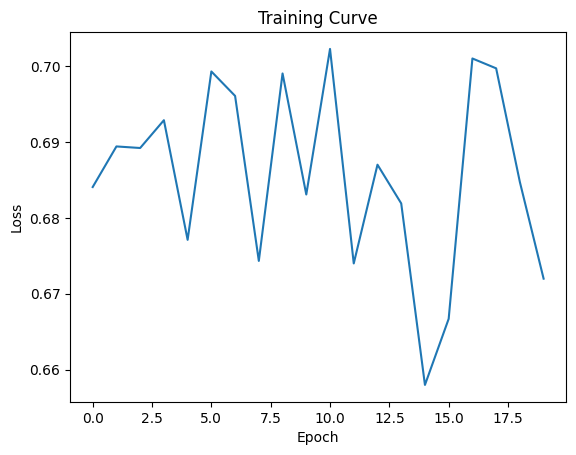

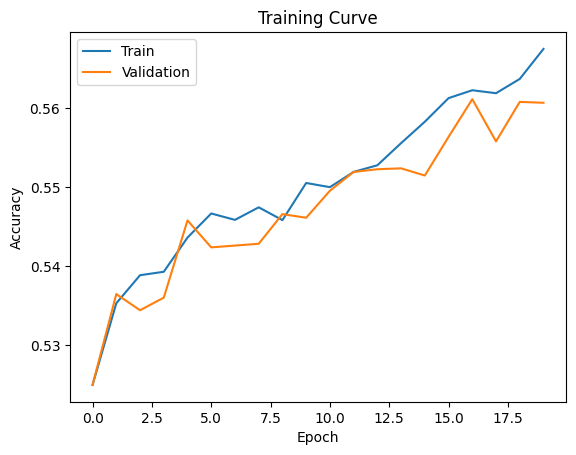

0.5648173453584768

In [16]:
class TweetGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetGRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the GRU 
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_gru = TweetGRU(50, 150, 2)
train_rnn_network(model_gru, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model_gru, test_loader)

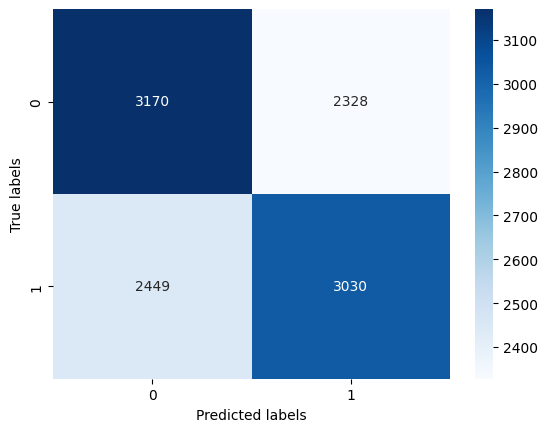

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model_gru.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = model_gru(x)
        _, preds = torch.max(output, 1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()